<a href="https://colab.research.google.com/github/aslla77/aslla77/blob/master/About_Hopfield_Network/Hopfeild_Network_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import pandas as pd

In [3]:
(x_train,t_train),(x_test,t_test)=tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
def hamming_d(img,L):
  h_distance = np.zeros([10,10])
  for i in range(10):
    for j in range(10):
      h_distance[i][j] = np.sum(img[i]!=img[j])
  return h_distance
  # # heatmap plot
  # heatmap=sns.heatmap(h_distance,cmap='Reds',annot=True,linewidth=0.5)
  # plt.show()

def count_in(arr):
  unique, counts = np.unique(arr, return_counts = True)
  uniq_cnt_dict = dict(zip(unique, counts))

  return(uniq_cnt_dict)

In [5]:
#resize , crop image ,  processing by the deskewing method , change to binary(0,1)
def deskewing(img):
  m=cv2.moments(img)
  if abs(m['mu02'])<1e-2:
    img=img
  else:
    skew=m['mu11']/m['mu02']
    M=np.float32([[1,skew,-0.5*28*skew],[0,1,0]])
    img=cv2.warpAffine(img,M,(0,0),flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)
  return img

def resize(img,L):
  margin_pixel=0

  contours,hierachy=cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
  rect=cv2.boundingRect(contours[0])
  x,y,w,h=rect[0],rect[1],rect[2],rect[3]
  im=img[y-margin_pixel:y+h+margin_pixel, x-margin_pixel:x+w+margin_pixel]
  row,col=im.shape[:2]

  #정방향 비율을 맞추기
  bordersize=max(row,col)
  diff=min(row,col)

  bottom=im[row-2:row,0:col]
  mean=cv2.mean(bottom)[0]

  border=cv2.copyMakeBorder(
      im,
      top=0,
      bottom=0,
      left=int((bordersize-diff)/2),
      right=int((bordersize-diff)/2),
      borderType=cv2.BORDER_CONSTANT,
      value=[0,0,0]

  )
  square=border
  resized_img=cv2.resize(square,dsize=(L,L),interpolation=cv2.INTER_AREA)
  return resized_img

def crop_avr_img_v1(size,Num):  #손글씨를 평균내어서 size로 잘라내는 함수
  xi = np.zeros([len(Num), size*size], dtype = 'float')
  ori = np.zeros([len(Num), 28*28], dtype = 'float')
  for i in range(len(Num)):
    a=list(np.where(t_train==Num[i])[0])
    b=np.zeros((28,28))
    for j in (a):
      dimg=deskewing(x_train[j])
      # resized=resize(dimg,size)
      b+=dimg
    c=b/len(a)
    ori[i]=c.reshape(28**2).copy()
    m=cv2.moments(c)
    cx=int(m['m10']/m['m00'])
    cy=int(m['m01']/m['m00'])
    c=c[cx-int(size//2):cx+int(size//2),cy-int(size//2):cy+int(size//2)]
    xi[i]=c.reshape(size*size)
    del(c)
  return  xi

def crop_avr_img(size,Num):  #손글씨를 평균내어서 size로 잘라내는 함수
  xi = np.zeros([len(Num), size*size], dtype = 'float')
  ori = np.zeros([len(Num), 28*28], dtype = 'float')
  for i in range(len(Num)):
    a=list(np.where(t_train==Num[i])[0])
    b=np.zeros((size,size))
    for j in (a):
      dimg=deskewing(x_train[j])
      resized=resize(dimg,size)
      b+=resized
    c=b/len(a)
    # ori[i]=c.reshape(28**2).copy()
    # m=cv2.moments(c)
    # cx=int(m['m10']/m['m00'])
    # cy=int(m['m01']/m['m00'])
    # c=c[cx-int(size//2):cx+int(size//2),cy-int(size//2):cy+int(size//2)]
    xi[i]=c.reshape(size*size)
    del(c)
  return  xi

def create_crop_img(size):
  xi = np.zeros([10, size*size], dtype = 'float')
  original_img=np.zeros([10, 28*28], dtype = 'float')
  for i in range(0,10):
    a=list(np.where(t_train==i)[0])
    img=x_train[a[np.random.randint(len(a))]]
    m=cv2.moments(img)
    cx=int(m['m10']/m['m00'])
    cy=int(m['m01']/m['m00'])
    original_img[i]=img.reshape(28*28).copy()
    img=img[cx-int(size//2):cx+int(size//2),cy-int(size//2):cy+int(size//2)]
    xi[i]=img.reshape(size*size)
    
  return original_img, xi

def change_binary(img,percent):
  ret,img=cv2.threshold(img,percent,255,cv2.THRESH_BINARY)
  img=img/255
  img[img<=0]=-1
  img[img>0]=1
  return  img

def crop(img,size):

  m=cv2.moments(img)
  cx=int(m['m10']/m['m00'])
  cy=int(m['m01']/m['m00'])
  out_img=img[cx-int(size/2):cx+int(size/2),cy-int(size/2):cy+int(size/2)]
  return out_img


def random_number(index,L,threshold,state=None):
  margin_pixel=0
  #random seed setting
  if state==None:
    pass
  else:
    np.random.seed(state)

  #create random number
  a=list(np.where(t_test==index)[0])
  img=x_test[a[np.random.randint(len(a))]]

  #save orignal_img
  ori=img.copy()

  #기울기보정 deskewing_img
  deskewing_img=deskewing(img)

  # resized_img=resize(deskewing_img,28)
  # crop_img=crop(resized_img,L)

  crop_img=crop(deskewing_img,L)


  S=change_binary(crop_img,threshold*0.02*255).reshape(L*L)

  return ori, S



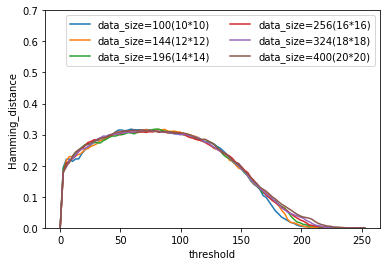

mindata: 0.31768707482993197
min threshold: 79.05 31
min_size: 14


In [10]:
data_size=[10,12,14,16,18,20]
mindata_r=1e-9
mindatathresh_r=0
mindatasize_r=0

for j in data_size:
  xdata_r=[]
  ydata_r=[]
  crop_img_r=crop_avr_img(j,list(i for i in range(10)))
  for i in range(0,100):
    crop_img_r_copy=crop_img_r.copy()
    binary_img_r=change_binary(crop_img_r_copy,i*0.01*255).reshape(10,j,j)
    h_distance_r=hamming_d(binary_img_r,j)/(j*j)
    tri_np_r=h_distance_r*(np.tri(10))
    ydata_r.append(np.sum(tri_np_r)/(45))
    xdata_r.append(i*0.01*255)
    if np.sum(tri_np_r)/(45)>mindata_r:
      mindata_r=np.sum(tri_np_r)/(45)
      mindatathresh_r=i
      mindatasize_r=j
  plt.plot(xdata_r,ydata_r,label='data_size={0:d}({1:d}*{1:d})'.format(j*j,j))

plt.xlabel('threshold')
plt.ylabel('Hamming_distance')
plt.legend(loc='upper right',ncol=2,fontsize=10)
plt.ylim(0,0.7)
plt.show()
print('mindata:',mindata_r)
print('min threshold:',mindatathresh_r*0.01*255,mindatathresh_r)
print('min_size:',mindatasize_r)

(10, 676)
resize averege image:26*26


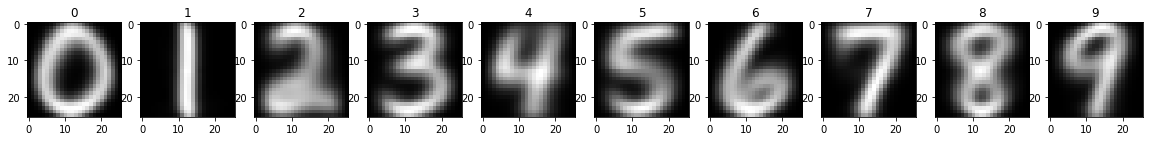

(10, 400)
resize averege image:20*20


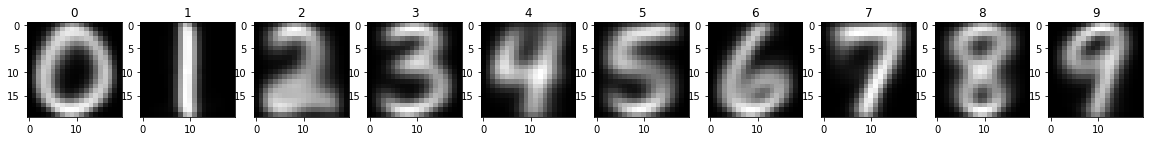

(10, 196)
resize averege image:14*14


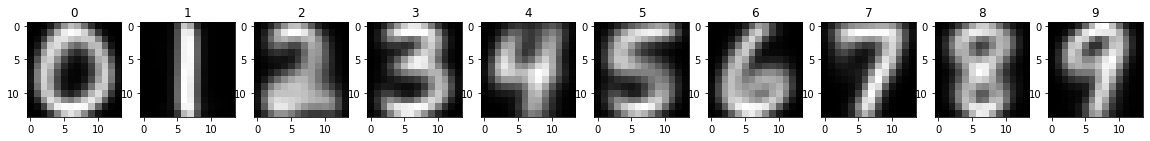

In [13]:
# if use cv2.resize
# size=(26,26)
img26=crop_avr_img(26,list(i for i in range(10)))
print(img26.shape)
print('resize averege image:26*26')

plt.figure(figsize=(20,20))
for i in range(len(img26)):
  plt.subplot(1,10,i+1)
  plt.imshow(img26[i].reshape(26,26),cmap='gray')
  plt.title('{:d}'.format(i))
plt.show()

#size=(20,20)
img20=crop_avr_img(20,list(i for i in range(10)))
print(img20.shape)
print('resize averege image:20*20')

plt.figure(figsize=(20,20))
for i in range(len(img20)):
  plt.subplot(1,10,i+1)
  plt.imshow(img20[i].reshape(20,20),cmap='gray')
  plt.title('{:d}'.format(i))
plt.show()

#size=(14,14)
img14=crop_avr_img(14,list(i for i in range(10)))
print(img14.shape)
print('resize averege image:14*14')

plt.figure(figsize=(20,20))
for i in range(len(img14)):
  plt.subplot(1,10,i+1)
  plt.imshow(img14[i].reshape(14,14),cmap='gray')
  plt.title('{:d}'.format(i))
plt.show()

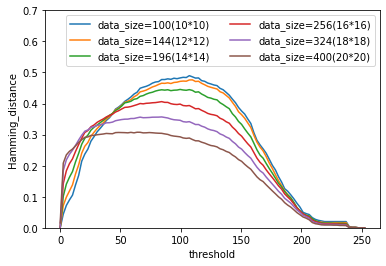

mindata: 0.4897777777777778
min threshold: 107.1 42
min_size: 10


In [9]:
data_size=[10,12,14,16,18,20]
mindata=1e-9
mindatathresh=0
mindatasize=0

for j in data_size:
  xdata=[]
  ydata=[]
  crop_img=crop_avr_img_v1(j,list(i for i in range(10)))
  for i in range(0,100):
    crop_img_copy=crop_img.copy()
    binary_img=change_binary(crop_img_copy,i*0.01*255).reshape(10,j,j)
    h_distance=hamming_d(binary_img,j)/(j*j)
    tri_np=h_distance*(np.tri(10))
    ydata.append(np.sum(tri_np)/(45))
    xdata.append(i*0.01*255)
    if np.sum(tri_np)/(45)>mindata:
      mindata=np.sum(tri_np)/(45)
      mindatathresh=i
      mindatasize=j
  plt.plot(xdata,ydata,label='data_size={0:d}({1:d}*{1:d})'.format(j*j,j))

plt.xlabel('threshold')
plt.ylabel('Hamming_distance')
plt.legend(loc='upper right',ncol=2,fontsize=10)
plt.ylim(0,0.7)
plt.show()
print('mindata:',mindata)
print('min threshold:',mindatathresh*0.01*255,mindatathresh)
print('min_size:',mindatasize)

(10, 100)
avarege image : (10*10)


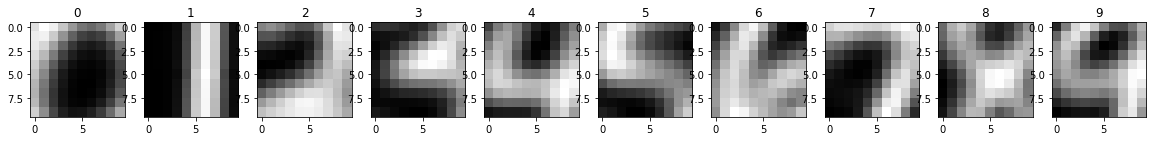

(10, 144)
avarege image : (12*12)


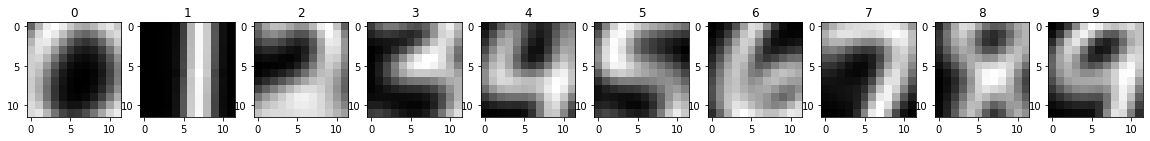

(10, 196)
avarege image : (14*14)


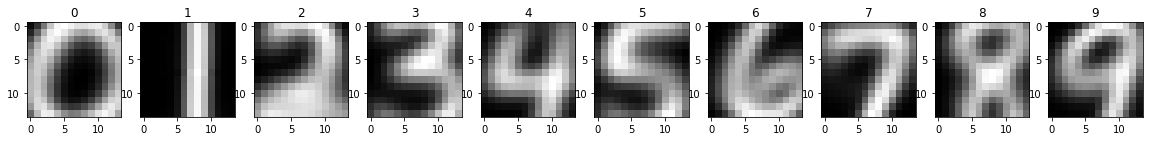

In [14]:
#before preprocessing
size=10
img=crop_avr_img_v1(size,list(i for i in range(10)))
print(img.shape)
print('avarege image : ({:d}*{:d})'.format(size,size))

plt.figure(figsize=(20,20))
for i in range(len(img)):
  plt.subplot(1,10,i+1)
  plt.imshow(img[i].reshape(size,size),cmap='gray')
  plt.title('{:d}'.format(i))
plt.show()

size=12
img=crop_avr_img_v1(size,list(i for i in range(10)))
print(img.shape)
print('avarege image : ({:d}*{:d})'.format(size,size))

plt.figure(figsize=(20,20))
for i in range(len(img)):
  plt.subplot(1,10,i+1)
  plt.imshow(img[i].reshape(size,size),cmap='gray')
  plt.title('{:d}'.format(i))
plt.show()

size=14
img=crop_avr_img_v1(size,list(i for i in range(10)))
print(img.shape)
print('avarege image : ({:d}*{:d})'.format(size,size))

plt.figure(figsize=(20,20))
for i in range(len(img)):
  plt.subplot(1,10,i+1)
  plt.imshow(img[i].reshape(size,size),cmap='gray')
  plt.title('{:d}'.format(i))
plt.show()

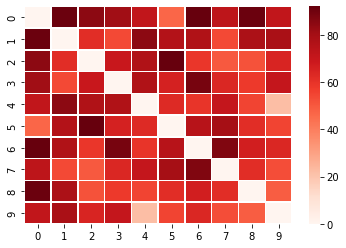

(array([0, 2, 5, 6]), array([6, 5, 2, 0]))
92.0 %
(array([4, 9]), array([9, 4]))
4and9 : 22.0 %


In [44]:

L=12
threshold=42
crop_img=crop_avr_img_v1(L,list(i for i in range(10)))
binary_img=change_binary(crop_img,threshold*0.01*255).reshape(10,L*L)
h_distance=(hamming_d(binary_img,L))

# heatmap plot
heatmap=sns.heatmap(h_distance,cmap='Reds',linewidth=0.5)
#,annot=True

plt.show()
print(np.where((h_distance)==np.max(h_distance)))
print(np.max(h_distance)/L*L,'%')
print(np.where((h_distance+np.eye(10)*100)==np.min(h_distance+np.eye(10)*100)))
print('4and9 :',h_distance[4,9]/L*L,'%')

after binary


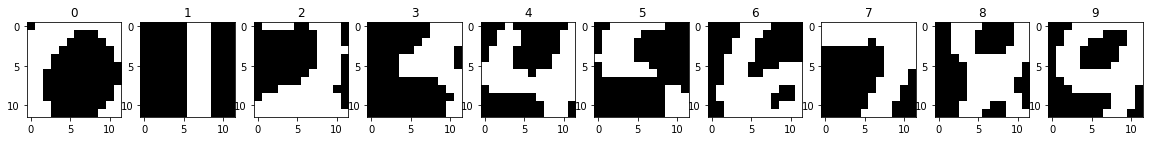

In [16]:
#before preprocessing
print('after binary')
plt.figure(figsize=(20,20))
for i in range(len(binary_img)):
  plt.subplot(1,10,i+1)
  plt.imshow(binary_img[i].reshape(L,L),cmap='gray')
  plt.title('{:d}'.format(i))
plt.show()

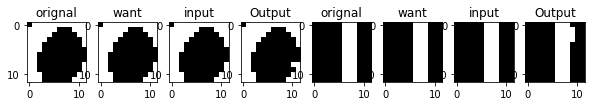

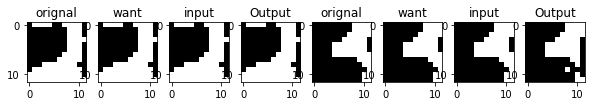

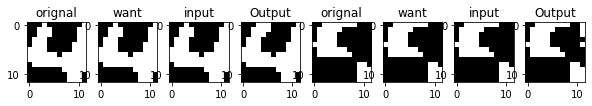

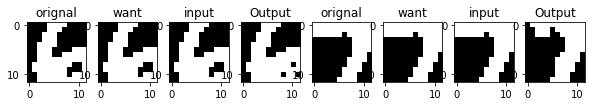

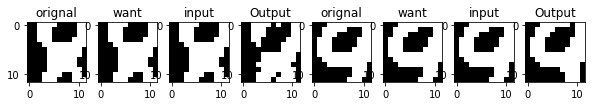

In [22]:
L=12
threshold=43
N=L*L


crop_avr_img1=crop_avr_img_v1(L,list(i for i in range(10)))
binary_avr_img=change_binary(crop_avr_img1,threshold*0.01*255).reshape(10,L,L)

index=1
plt.figure(figsize=(10,10))
xi=binary_avr_img.copy().reshape(10,L*L)

unique, counts = np.unique(xi, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))


# J = (xi.T@xi)-np.eye(L*L)*10
J=(xi.T@xi)/10 

for xinum in range(10):
  
  S=xi[xinum].copy()
  plt.subplot(1,8,index)
  plt.imshow(S.reshape(L,L),cmap='gray')
  plt.title('orignal')

  index+=1

  plt.subplot(1,8,index)
  plt.imshow(xi[xinum].reshape(L,L),cmap="gray")
  plt.title('want')
  index+=1

  #input image
  plt.subplot(1,8,index)
  plt.imshow(S.reshape(L,L),cmap="gray")
  plt.title('input')
  index+=1

  F= J@S
  for counter in range(6000):
    for k in range(N):
      dE = 2*(F[k]*S[k] - J[k][k])
      if dE < 0:
        for i in range(N):
          F[i] -= 2*J[i][k]*S[k]        
        S[k] *= -1

  #output image
  plt.subplot(1,8,index)
  plt.imshow(S.reshape(L,L), cmap="gray")
  plt.title('Output')
  
  if index ==8:
    plt.show()
    if xinum != 9:
      plt.figure(figsize=(10,10))
    index=0
  index+=1


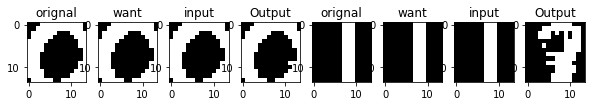

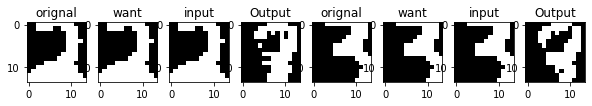

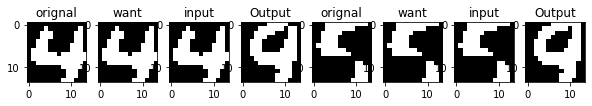

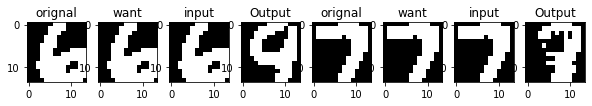

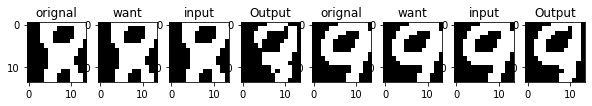

In [23]:
L=14
threshold=43
N=L*L


crop_avr_img1=crop_avr_img_v1(L,list(i for i in range(10)))
binary_avr_img=change_binary(crop_avr_img1,threshold*0.01*255).reshape(10,L,L)

index=1
plt.figure(figsize=(10,10))
xi=binary_avr_img.copy().reshape(10,L*L)

unique, counts = np.unique(xi, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))


J = (xi.T@xi)-np.eye(L*L)*10
# J=(xi.T@xi)/10 

for xinum in range(10):
  
  S=xi[xinum].copy()
  plt.subplot(1,8,index)
  plt.imshow(S.reshape(L,L),cmap='gray')
  plt.title('orignal')

  index+=1

  plt.subplot(1,8,index)
  plt.imshow(xi[xinum].reshape(L,L),cmap="gray")
  plt.title('want')
  index+=1

  #input image
  plt.subplot(1,8,index)
  plt.imshow(S.reshape(L,L),cmap="gray")
  plt.title('input')
  index+=1

  F= J@S
  for counter in range(6000):
    for k in range(N):
      dE = 2*(F[k]*S[k] - J[k][k])
      if dE < 0:
        for i in range(N):
          F[i] -= 2*J[i][k]*S[k]        
        S[k] *= -1

  #output image
  plt.subplot(1,8,index)
  plt.imshow(S.reshape(L,L), cmap="gray")
  plt.title('Output')
  
  if index ==8:
    plt.show()
    if xinum != 9:
      plt.figure(figsize=(10,10))
    index=0
  index+=1


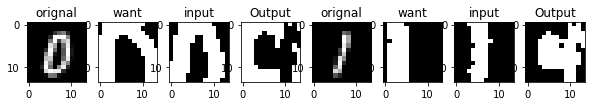

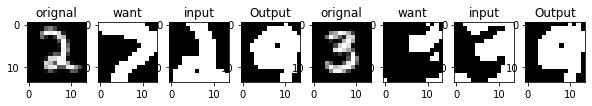

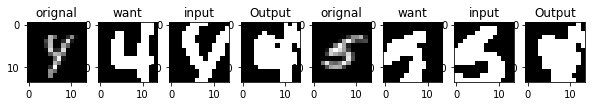

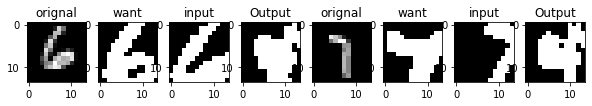

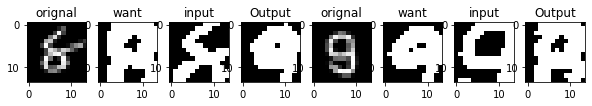

<Figure size 720x720 with 0 Axes>

In [24]:
L=14
threshold=15
N=L*L
orignal_img, not_avr_img=create_crop_img(L)

d_ori_img=np.ones_like(orignal_img).reshape(10,28*28)
d_single_img=np.ones_like(not_avr_img).reshape(10,L*L)

for i in range(10):
  d_ori_img[i]=deskewing(orignal_img[i].reshape(28,28)).reshape(28*28)
  d_single_img[i]=deskewing(not_avr_img[i].reshape(L,L)).reshape(L*L)

binary_single_img=change_binary(d_single_img,threshold*0.01*255).reshape(10,L,L)


index=1
plt.figure(figsize=(10,10))

single_xi=binary_single_img.copy().reshape(10,L*L)


J = (single_xi.T@single_xi)/10


for xinum in range(10):
  a=list(np.where(t_test==xinum)[0])
  img=x_test[a[np.random.randint(len(a))]]

  

  plt.subplot(1,8,index)
  plt.imshow(np.array(cv2.resize(img.reshape(28,28),(L,L))),cmap='gray')
  plt.title('orignal')
  index+=1

  crop_img=crop(img,L)
  deskewing_img=deskewing(crop_img)
  S=change_binary(deskewing_img,threshold*0.01*255).reshape(L*L)

  #input image
  plt.subplot(1,8,index)
  plt.imshow(single_xi[xinum].reshape(L,L),cmap="gray")
  plt.title('want')
  index+=1

  plt.subplot(1,8,index)
  plt.imshow(S.reshape(L,L),cmap="gray")
  plt.title('input')
  index+=1
  


  F=J@S
  for counter in range(5000):
    for k in range(N):
      dE = 2*(F[k]*S[k] - J[k][k])
      if dE < 0:
        for i in range(N):
          F[i] -= 2*J[i][k]*S[k]        
        S[k] *= -1

  #output image
  plt.subplot(1,8,index)
  plt.imshow(S.reshape(L,L), cmap="gray")
  plt.title('Output')
  
  if index ==8:
    plt.show()
    plt.figure(figsize=(10,10))
    index=0
  index+=1


In [25]:
class hopfield:
  def __init__(self,L,threshold,MaxStep,avr=False):
    global x_train,x_test
    self.L=L
    self.N=self.L**2
    self.threshold=threshold
    self.MaxStep=MaxStep
    self.avr=avr

    if isinstance(avr,list)==True:
      crop_img=crop_avr_img_v1(self.L,avr)
      binary_img=change_binary(crop_img,self.threshold).reshape(len(avr),self.L**2)
      self.xi=binary_img.copy()

    elif avr==True:
      self.avr=list(i for i in range(0,10))
      crop_avr_img1=crop_avr_img_v1(self.L,list(i for i in range(10)))
      binary_avr_img=change_binary(crop_avr_img1,self.threshold).reshape(10,self.L**2)
      self.xi=binary_avr_img.copy()

    elif avr!=True:
      self.avr=list(i for i in range(0,10))
      self.ori_img, not_avr_img=create_crop_img(self.L)
      d_single_img=np.ones_like(not_avr_img).reshape(10,self.L**2)

      for i in range(10):
        d_single_img[i]=deskewing(not_avr_img[i].reshape(self.L,self.L)).reshape(self.L**2)
      binary_single_img=change_binary(d_single_img,self.threshold).reshape(10,self.L**2)
      self.xi=binary_single_img.copy()

    plt.figure(figsize=(len(self.xi),2))

    for i in range(len(self.xi)):
      plt.subplot(1,len(self.xi),i+1)
      plt.imshow(self.xi[i].reshape(self.L,self.L),cmap='gray')
    plt.suptitle('reference pattern',x=0.5,y=0.85)
    plt.show()

  def run(self,S):
    self.J = (self.xi.T@self.xi)/len(self.xi)
    self.ori=S.copy()
    self.S=S.copy()
    index=1

    self.F=self.J@self.S
    for counter in range(self.MaxStep):
      for k in range(self.N):
        dE = 2*(self.F[k]*self.S[k] - self.J[k][k])
        if dE < 0:
          for i in range(self.N):
            self.F[i] -= 2*self.J[i][k]*self.S[k]        
          self.S[k] *= -1
         
    return self.S 

  def plot_show(self):
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(self.ori.reshape(self.L,self.L),cmap='gray')
    plt.title('input')
    plt.subplot(1,2,2)
    plt.imshow(self.S.reshape(self.L,self.L),cmap='gray')
    plt.title('output')
    plt.show()
  
  def similiarity(self):
    simi=1e-9
    simi1=1e-9
    for i in range(len(self.xi)):
      data=np.sum(self.xi[i]==self.S)/(self.L**2)
      if data<=0.2:
        data=np.sum(self.xi[i]*(-1)==self.S)/(self.L**2)
        self.S=self.S*(-1)
        
      if data>simi :
        simi=data
        simi_index=self.avr[i]

    return simi,simi_index

  def compare(self,index):
    data=np.sum(self.xi[self.avr.index(index)]==self.S)/(self.L**2)
    if data<=0.2:
      data=np.sum(self.xi[self.avr.index(index)]*(-1)==self.S)/(self.L**2)
    return data

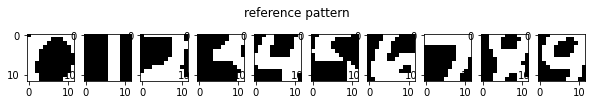

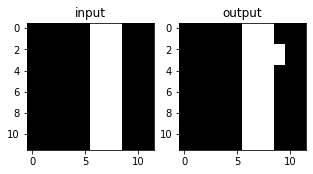

In [28]:
a=hopfield(12,107.1,4000,True) 
img=a.xi[1].copy()
a.run(img)
a.plot_show()

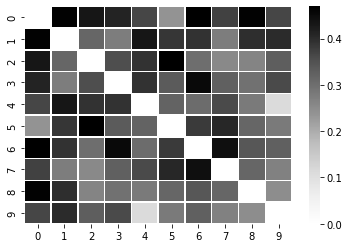

min: 0.11224489795918367
(array([4, 9]), array([9, 4]))

index: (0, 1, 9)
index' combinations: 0.7704081632653061
9's list: [0.36734694 0.40306122 0.33163265 0.3622449  0.1122449  0.28061224
 0.32653061 0.27040816 0.25       0.        ]

index: (2, 3, 4)
index' combinations: 0.7857142857142857
4's list: [0.36734694 0.43367347 0.39285714 0.39285714 0.         0.32142857
 0.30612245 0.3622449  0.28061224 0.1122449 ]


In [48]:
from itertools import combinations
h_distance=(hamming_d(a.xi,14))/(14**2)

# heatmap plot
heatmap=sns.heatmap(h_distance,cmap='Greys',linewidth=0.5)
#,annot=True

plt.show()
num=9
print('min:',np.min(h_distance+np.eye(10)*100))
print(np.where((h_distance+np.eye(10)*100)==np.min(h_distance+np.eye(10)*100)))
Min=1e-9
for i,j in combinations(list(i for i in range(len(h_distance[num])) if i!=num ),2):
  if Min<np.sum(h_distance[num][[i,j]]):
    Min=np.sum(h_distance[num][[i,j]])
    index=(i,j,num)
print('\nindex:',index)
print('index\' combinations:',Min)
print('{:d}\'s list:'.format(num),h_distance[num])

Min=1e-9
num=4
for i,j in combinations(list(i for i in range(len(h_distance[num])) if not(i in index)and i!=num),2):
  if Min<np.sum(h_distance[num][[i,j]]):
    Min=np.sum(h_distance[num][[i,j]])
    index=(i,j,num)
print('\nindex:',index)
print('index\' combinations:',Min)
print('{:d}\'s list:'.format(num),h_distance[num])
#1,2,4 // 0,3,9

In [49]:
#multi perceptron 구조에서 방식을 따와 중복도가 낮은 숫자의 조합끼리 묶어서 결과값을 출력

class perceptron(hopfield):
  def __init__(self,L,threshold,MaxStep,list1=[1,2,4],list2=[0,3,9],list3=[5,6,7,8]):
    self.L=L
    self.N=L**2
    self.threshold=threshold
    self.MaxStep=MaxStep
   
    self.perceptron1=hopfield(self.L,self.threshold,self.MaxStep,list1)
    self.perceptron2=hopfield(self.L,self.threshold,self.MaxStep,list2)
    self.perceptron3=hopfield(self.L,self.threshold,self.MaxStep,list3)

  def run(self,S):
    self.S=S.copy()
    self.xi_2=np.empty((0,self.N))
    self.numdata=[]

    self.img=S.copy()
    S1=self.perceptron1.run(self.img)

    self.img=S.copy()
    S2=self.perceptron2.run(self.img)

    self.img=S.copy()
    S3=self.perceptron3.run(self.img)

    percent_1,num_index_1=self.perceptron1.similiarity()
    percent_2,num_index_2=self.perceptron2.similiarity()
    percent_3,num_index_3=self.perceptron3.similiarity()
    self.index1=None

    if percent_1>=0.85:
      self.xi_2=np.append(self.xi_2,np.array([S1]),axis=0)
      self.numdata.append(num_index_1)

    if percent_2>=0.85:
      self.xi_2=np.append(self.xi_2,np.array([S2]),axis=0)
      self.numdata.append(num_index_2)

    if percent_3>=0.85:
      self.xi_2=np.append(self.xi_2,np.array([S3]),axis=0)
      self.numdata.append(num_index_3)

    if self.xi_2.shape[0]==0:
      return self.S ,self.index1

    else:
      self.J = (self.xi_2.T@self.xi_2)/len(self.xi_2)
      self.F=self.J@self.S

      for counter in range(self.MaxStep):
        for k in range(self.N):
          dE = 2*(self.F[k]*self.S[k] - self.J[k][k])
          if dE < 0:
            for i in range(self.N):
              self.F[i] -= 2*self.J[i][k]*self.S[k]        
            self.S[k] *= -1

      percent1,self.index1=self.similiarity1()

    return self.S ,self.index1

  def similiarity1(self):
    simi_xi2=1e-9

    for i in range(len(self.xi_2)):
      data_xi2=np.sum(self.xi_2[i]==self.S)/(self.L**2)
      if data_xi2<=0.2:
        data_xi2=np.sum(self.xi_2[i]*(-1)==self.S)/(self.L**2)

      if data_xi2>simi_xi2 :
        simi_xi2=data_xi2
        simi_index_xi2=self.numdata[i]

    return simi_xi2,simi_index_xi2


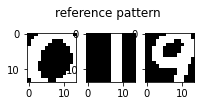

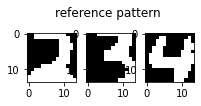

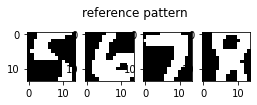

In [50]:
num=9
thresholdd=15
L=14
#L:crop_size, threshold:107.1, MaxStep:4000, list1,list2,list3=perceptron1
ss=perceptron(L,107.10,5000,[0,1,9],[2,3,4],[5,6,7,8] ) 
# 실행시 기준 패턴을 보여줌

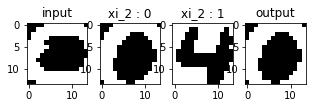

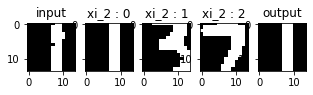

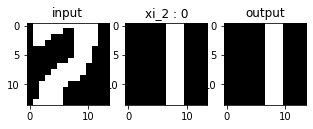

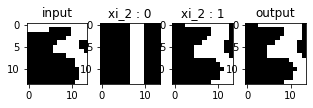

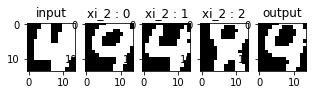

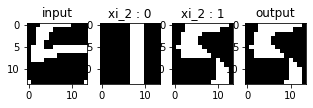

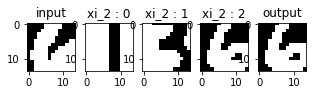

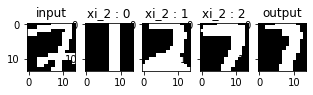

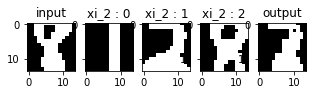

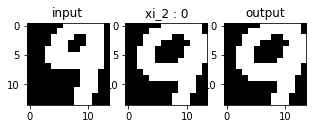

In [51]:
for i in range(10):
  plt.figure(figsize=(5,5))
  ori_img,img=random_number(i,L,thresholdd)
  S,index=ss.run(img)
  z=len(ss.xi_2)+2
  plt.subplot(1,z,1)
  plt.imshow(img.reshape(L,L),cmap='gray')
  plt.title('input')

  for k in range(len(ss.xi_2)):                       #옳은 정답을 찾을 경우 2계층의 연상기억 장치에 들어가는 패턴들
    plt.subplot(1,z,k+2)
    plt.imshow(ss.xi_2[k].reshape(L,L),cmap='gray')
    plt.title('xi_2 : {:d}'.format(k))
  
  plt.subplot(1,z,z)
  plt.imshow(S.reshape(L,L),cmap='gray')
  plt.title('output')  
  plt.show()

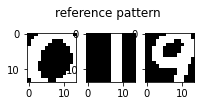

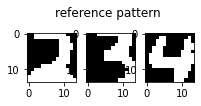

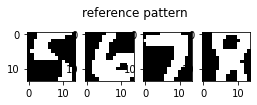

0 1 2 3 4 5 6 7 8 9 

In [ ]:
#@title 기본 제목 텍스트
#실행시 오래 걸리기에 생략

step=50
thresholdd=15
random_state=42
L=14

correct_data=dict(zip([i for i in range(10)], [0 for i in range(10)]))                        # 찾은 정답 확률
worng_data=dict(zip([i for i in range(10)], [0 for i in range(10)]))                          # 못찾은 데이터들
uncorrect_data=dict(zip([i for i in range(10)], [[0 for i in range(10)] for i in range(10)])) # 틀린 정답 위치들
check=perceptron(L,107.10,3000,[0,1,9],[2,3,4],[5,6,7,8]) #124/039/5678

for i in range(10):
  print(i,end=' ')
  for j in range(step):                         #각숫자 당 step 만큼의 랜덤의 숫자 입력
    ori_img,img=random_number(i,L,thresholdd)
    S,index=check.run(img)
    if index==None:                             # 못찾은 데이터
      worng_data[i]+=1
    elif i==index:                              # 정답일 경우
      correct_data[i]+=1/step*100
    else :                                      # 틀린 정답일 경우
      uncorrect_data[i][index]+=1



In [ ]:
print(correct_data)
print(uncorrect_data)
print(worng_data)

{0: 60.0, 1: 96.0, 2: 50.0, 3: 68.0, 4: 46.0, 5: 42.0, 6: 58.0, 7: 70.0, 8: 58.0, 9: 70.0}
{0: [0, 3, 2, 2, 0, 4, 6, 1, 1, 0], 1: [0, 0, 0, 0, 0, 0, 0, 2, 0, 0], 2: [2, 7, 0, 2, 0, 0, 0, 10, 3, 1], 3: [0, 7, 0, 0, 0, 0, 0, 3, 4, 2], 4: [2, 6, 0, 0, 0, 1, 4, 3, 0, 9], 5: [2, 2, 0, 8, 0, 0, 2, 2, 0, 13], 6: [4, 3, 0, 2, 7, 1, 0, 0, 1, 2], 7: [0, 0, 2, 0, 2, 0, 0, 0, 0, 11], 8: [0, 2, 1, 3, 4, 1, 0, 1, 0, 9], 9: [0, 3, 0, 3, 5, 0, 0, 2, 0, 0]}
{0: 1, 1: 0, 2: 0, 3: 0, 4: 2, 5: 0, 6: 1, 7: 0, 8: 0, 9: 2}


In [ ]:
un_correct_data_df=pd.DataFrame(uncorrect_data)

correct_data_S=pd.Series(correct_data,
                    index=[0,1,2,3,4,5,6,7,8,9])

unfind_S=pd.Series(worng_data,
                   index=[0,1,2,3,4,5,6,7,8,9])

unfind_S.to_csv('01_unfind_data.csv')
un_correct_data_df.T.to_csv('01_uncorrect_data.csv')
correct_data_S.to_csv('01_correct_data.csv')

In [ ]:

worng_percent=np.zeros((10))
un_find_percent=np.zeros((10))
total=[]
most_confuse={}
confu_data=[]
for i in range(10):
  un_find_percent[i]=sum(uncorrect_data[i])/step*100
  worng_percent[i]=worng_data[i]/step*100
  print(i,':',count_in(uncorrect_data[i]))
  confu_data.append(uncorrect_data[i].index(max(count_in(uncorrect_data[i]))))
  total.append(sum(uncorrect_data[i])/step*100+worng_data[i]/step*100+correct_data[i])
print(confu_data)
print(total)

0 : {0: 3, 1: 2, 2: 2, 3: 1, 4: 1, 6: 1}
1 : {0: 9, 2: 1}
2 : {0: 4, 1: 1, 2: 2, 3: 1, 7: 1, 10: 1}
3 : {0: 6, 2: 1, 3: 1, 4: 1, 7: 1}
4 : {0: 4, 1: 1, 2: 1, 3: 1, 4: 1, 6: 1, 9: 1}
5 : {0: 4, 2: 4, 8: 1, 13: 1}
6 : {0: 3, 1: 2, 2: 2, 3: 1, 4: 1, 7: 1}
7 : {0: 7, 2: 2, 11: 1}
8 : {0: 3, 1: 3, 2: 1, 3: 1, 4: 1, 9: 1}
9 : {0: 6, 2: 1, 3: 2, 5: 1}
[6, 7, 7, 1, 9, 9, 4, 9, 9, 4]
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


In [ ]:

a='Percent of correct classification (%)'
b='Percent of incorrect classification (%)'
c='Percent of spurious patterns (%)'
d='most confused number'
df=pd.DataFrame({a:correct_data,
                b:worng_percent,
                c:un_find_percent,
                d:confu_data,
                'total(%)':total},
                index=[i for i in range(10)])
df.to_csv('01_total data.csv')
df

,Percent of correct classification (%),Percent of incorrect classification (%),Percent of spurious patterns (%),most confused number,total(%)
0,60.0,2.0,38.0,6,100.0
1,96.0,0.0,4.0,7,100.0
2,50.0,0.0,50.0,7,100.0
3,68.0,0.0,32.0,1,100.0
4,46.0,4.0,50.0,9,100.0
5,42.0,0.0,58.0,9,100.0
6,58.0,2.0,40.0,4,100.0
7,70.0,0.0,30.0,9,100.0
8,58.0,0.0,42.0,9,100.0
9,70.0,4.0,26.0,4,100.0


In [ ]:
first_df=pd.read_csv('/content/drive/MyDrive/datafolder/final project/total data.csv',index_col=0)
first_df

,Percent of correct classification (%),Percent of incorrect classification (%),Percent of spurious patterns (%),most confused number,total(%)
0,62.0,0.0,38.0,6,100.0
1,94.0,0.0,6.0,0,100.0
2,52.0,0.0,48.0,8,100.0
3,82.0,2.0,16.0,1,100.0
4,50.0,4.0,46.0,9,100.0
5,48.0,0.0,52.0,9,100.0
6,56.0,0.0,44.0,1,100.0
7,54.0,0.0,46.0,9,100.0
8,46.0,2.0,52.0,9,100.0
9,56.0,4.0,40.0,0,100.0


In [ ]:
second_df=pd.read_csv('/content/drive/MyDrive/datafolder/final project/01_total data.csv',index_col=0)
second_df

,Percent of correct classification (%),Percent of incorrect classification (%),Percent of spurious patterns (%),most confused number,total(%)
0,60.0,2.0,38.0,6,100.0
1,96.0,0.0,4.0,7,100.0
2,50.0,0.0,50.0,7,100.0
3,68.0,0.0,32.0,1,100.0
4,46.0,4.0,50.0,9,100.0
5,42.0,0.0,58.0,9,100.0
6,58.0,2.0,40.0,4,100.0
7,70.0,0.0,30.0,9,100.0
8,58.0,0.0,42.0,9,100.0
9,70.0,4.0,26.0,4,100.0


In [ ]:
a='Percent of correct classification (%)'
b='Percent of incorrect classification (%)'
c='Percent of spurious patterns (%)'
d='most confused number'
print(first_df[a])
print(second_df[a])
print(np.sum(first_df[a].values)/10)
print(np.sum(second_df[a].values)/10)

0    62.0
1    94.0
2    52.0
3    82.0
4    50.0
5    48.0
6    56.0
7    54.0
8    46.0
9    56.0
Name: Percent of correct classification (%), dtype: float64
0    60.0
1    96.0
2    50.0
3    68.0
4    46.0
5    42.0
6    58.0
7    70.0
8    58.0
9    70.0
Name: Percent of correct classification (%), dtype: float64
60.0
61.8


In [ ]:
first_df.describe()

,Percent of correct classification (%),Percent of incorrect classification (%),Percent of spurious patterns (%),most confused number,total(%)
count,10.00000,10.000000,10.00000,10.000000,10.0
mean,60.00000,1.200000,38.80000,5.200000,100.0
std,15.69147,1.686548,15.49767,4.157991,0.0
min,46.00000,0.000000,6.00000,0.000000,100.0
25%,50.50000,0.000000,38.50000,1.000000,100.0
50%,55.00000,0.000000,45.00000,7.000000,100.0
75%,60.50000,2.000000,47.50000,9.000000,100.0
max,94.00000,4.000000,52.00000,9.000000,100.0


In [ ]:
second_df.describe()

,Percent of correct classification (%),Percent of incorrect classification (%),Percent of spurious patterns (%),most confused number,total(%)
count,10.000000,10.000000,10.000000,10.000000,10.0
mean,61.800000,1.200000,37.000000,6.500000,100.0
std,15.476147,1.686548,15.267977,2.758824,0.0
min,42.000000,0.000000,4.000000,1.000000,100.0
25%,52.000000,0.000000,30.500000,4.500000,100.0
50%,59.000000,0.000000,39.000000,7.000000,100.0
75%,69.500000,2.000000,48.000000,9.000000,100.0
max,96.000000,4.000000,58.000000,9.000000,100.0


In [110]:
#앙상블 voting방식을 이용하여 2개씩 조합 된 홉필드 연상장치를 여러개 붙여서 그중 가장 강력한 수를 가진 결과값을 출력
class ensemble(hopfield):
  def __init__(self,L,threshold,MaxStep,avr=True):
    super().__init__(L,threshold,MaxStep,avr)

  def run(self,S):
    data=np.zeros(10)
    for num1,num2 in combinations(list(i for i in range(10)),2):
      self.S=S.copy()
      temporary_xi=np.zeros([2,L*L])
      temporary_xi[0]=self.xi[num1]
      temporary_xi[1]=self.xi[num2]

      self.J = (temporary_xi.T@temporary_xi)/2
      self.F=self.J@self.S

      for counter in range(self.MaxStep):
        for k in range(self.N):
          dE = 2*(self.F[k]*self.S[k] - self.J[k][k])
          if dE < 0:
            for i in range(self.N):
              self.F[i] -= 2*self.J[i][k]*self.S[k]        
            self.S[k] *= -1


      if np.sum(self.S==temporary_xi[0])/self.N >=0.85:
        data[num1]+=1
      elif np.sum(self.S==temporary_xi[1])/self.N >=0.85:
        data[num2]+=1
      else:
        pass

    return data




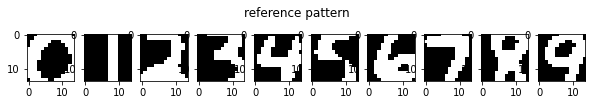

0 1 2 3 4 5 6 7 8 9 0 : [15, 0, 0, 0, 0, 3, 2, 0, 0, 0]
1 : [0, 19, 0, 0, 0, 0, 0, 0, 1, 0]
2 : [0, 1, 17, 0, 0, 0, 0, 2, 0, 0]
3 : [0, 2, 1, 13, 0, 2, 0, 1, 1, 0]
4 : [0, 0, 0, 0, 15, 1, 3, 0, 0, 1]
5 : [0, 2, 0, 4, 0, 13, 0, 1, 0, 0]
6 : [2, 0, 3, 0, 2, 1, 12, 0, 0, 0]
7 : [1, 3, 1, 0, 1, 0, 0, 13, 0, 1]
8 : [0, 0, 0, 1, 1, 0, 0, 0, 17, 1]
9 : [2, 2, 0, 0, 3, 0, 0, 1, 0, 12]


In [129]:

thresholdd=15
random_state=42
L=14

test_ens=ensemble(L,107.10,300,True)

data_list=dict(zip([i for i in range(10)], [[0 for i in range(10)] for i in range(10)]))

for i in range(10): 
  print(i,end=' ')
  for __ in range(20):                       
    ori_img,img=random_number(i,L,thresholdd)
    pred=test_ens.run(img)
    data_list[i][np.where(pred==np.max(pred))[0][0]]+=1

for i in range(10):
  print(i,':',data_list[i])


In [132]:
df=pd.DataFrame(data_list,
                index=[i for i in range(10)])
df.T

,0,1,2,3,4,5,6,7,8,9
0,15,0,0,0,0,3,2,0,0,0
1,0,19,0,0,0,0,0,0,1,0
2,0,1,17,0,0,0,0,2,0,0
3,0,2,1,13,0,2,0,1,1,0
4,0,0,0,0,15,1,3,0,0,1
5,0,2,0,4,0,13,0,1,0,0
6,2,0,3,0,2,1,12,0,0,0
7,1,3,1,0,1,0,0,13,0,1
8,0,0,0,1,1,0,0,0,17,1
9,2,2,0,0,3,0,0,1,0,12


In [140]:
print('number/ total /correct percent(%)')
tot=0
for i in range(10):
  print(i,'    |   ',sum(data_list[i]),end=' |   ')
  print('',data_list[i][i]/20 *100)
  tot+=data_list[i][i]/20 *100
print('average percent:', tot/10)

number/ total /correct percent(%)
0     |    20 |    75.0
1     |    20 |    95.0
2     |    20 |    85.0
3     |    20 |    65.0
4     |    20 |    75.0
5     |    20 |    65.0
6     |    20 |    60.0
7     |    20 |    65.0
8     |    20 |    85.0
9     |    20 |    60.0
average percent: 73.0
